# Introduction - A Prediction:

The task in this notebook is to refine a custom model to tell apart the chext x-rays with no findings from those that have some pathology. It is a binary classification task.

Continuing from the work done in the analysis of the NIH Chest x-ray dataset here: [https://www.kaggle.com/code/naijaoracle/nih-chest-x-ray-dataset-analysis](http://) 

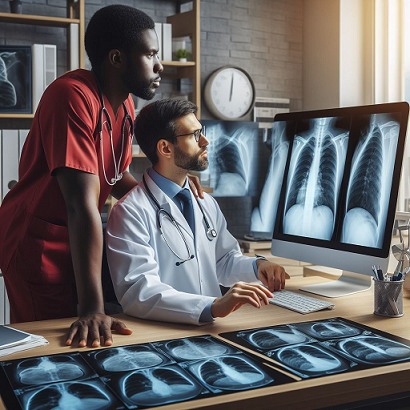

# File loading and data overview

In [1]:
import numpy as np 
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from IPython.display import FileLink
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import copy
import glob
import sys
import os
import shutil

warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
%%capture
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:

try:
    df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv', delimiter=',')
except FileNotFoundError as e:
    print(f"Error: {e}")
    

In [4]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


# Data Cleaning and preprocessing

In [6]:
column_list = df.columns.tolist()
print(column_list)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


In [7]:
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

df['Finding Labels'] = df['Finding Labels'].astype(str)

df['Finding Labels'] = df['Finding Labels'].str.split('|')

df['Finding Labels'] = df['Finding Labels'].apply(lambda x: ', '.join(x))

In [8]:
df[1000:1005]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
1000,00000246_018.png,No Finding,18,246,44,M
1001,00000246_019.png,No Finding,19,246,45,M
1002,00000247_000.png,Pleural_Thickening,0,247,43,M
1003,00000248_000.png,"Emphysema, Mass",0,248,87,M
1004,00000248_001.png,No Finding,1,248,87,M


In [9]:
df.loc[:, 'Finding Labels'] = df['Finding Labels'].astype(str)

df = df[~df['Finding Labels'].str.contains(',')]

In [10]:
df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
112114,00030801_000.png,No Finding,0,30801,39,M
112116,00030802_000.png,No Finding,0,30802,29,M
112117,00030803_000.png,No Finding,0,30803,42,F
112118,00030804_000.png,No Finding,0,30804,30,F
112119,00030805_000.png,No Finding,0,30805,27,M


In [11]:
print(df['Finding Labels'].value_counts())

Finding Labels
No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
Name: count, dtype: int64


In [12]:
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
selected_conditions = ['No Finding', 'Effusion', 'Infiltration', 'Atelectasis', 'Nodule']

df = df[df['Finding Labels'].isin(selected_conditions)]

In [13]:
df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
112114,00030801_000.png,No Finding,0,30801,39,M
112116,00030802_000.png,No Finding,0,30802,29,M
112117,00030803_000.png,No Finding,0,30803,42,F
112118,00030804_000.png,No Finding,0,30804,30,F
112119,00030805_000.png,No Finding,0,30805,27,M


In [14]:
print(df['Finding Labels'].value_counts())
print(f"Total: {len(df)}")

Finding Labels
No Finding      60361
Infiltration     9547
Atelectasis      4215
Effusion         3955
Nodule           2705
Name: count, dtype: int64
Total: 80783


In [15]:
max_samples_per_condition = 3000


sampled_dfs = []
for label, group in df.groupby('Finding Labels'):
    if len(group) > max_samples_per_condition:
        sampled_group = group.sample(n=max_samples_per_condition, replace=False)
    else:
        sampled_group = group

    sampled_dfs.append(sampled_group)


sampled_df = pd.concat(sampled_dfs)

In [16]:
print(len(sampled_df))

14705


In [17]:
sampled_df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
111967,00030697_000.png,Nodule,0,30697,42,F
111975,00030703_000.png,Nodule,0,30703,58,F
111976,00030703_001.png,Nodule,1,30703,58,F
112001,00030722_000.png,Nodule,0,30722,45,F
112005,00030726_000.png,Nodule,0,30726,64,M


In [18]:
print(sampled_df['Finding Labels'].value_counts())

Finding Labels
Atelectasis     3000
Effusion        3000
Infiltration    3000
No Finding      3000
Nodule          2705
Name: count, dtype: int64


## Chest x-rays with findings vs no findings.

We can see that approximately 54% of the chest x-rays in this dataset are labelled as having no findings, this can present challenges or learning opportunities depending on what we want to do with our data.
We may want to know what features differentiate those with no findings from those with findings. 

For machine learning we may want to take measures to ensure having a large number of ‘No Finding’ images does not bias the model towards predicting ‘No Finding'.

In [19]:
# Load the images
root_folder = "/kaggle/input/data/"

try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    

In [20]:
df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
112114,00030801_000.png,No Finding,0,30801,39,M
112116,00030802_000.png,No Finding,0,30802,29,M
112117,00030803_000.png,No Finding,0,30803,42,F
112118,00030804_000.png,No Finding,0,30804,30,F
112119,00030805_000.png,No Finding,0,30805,27,M


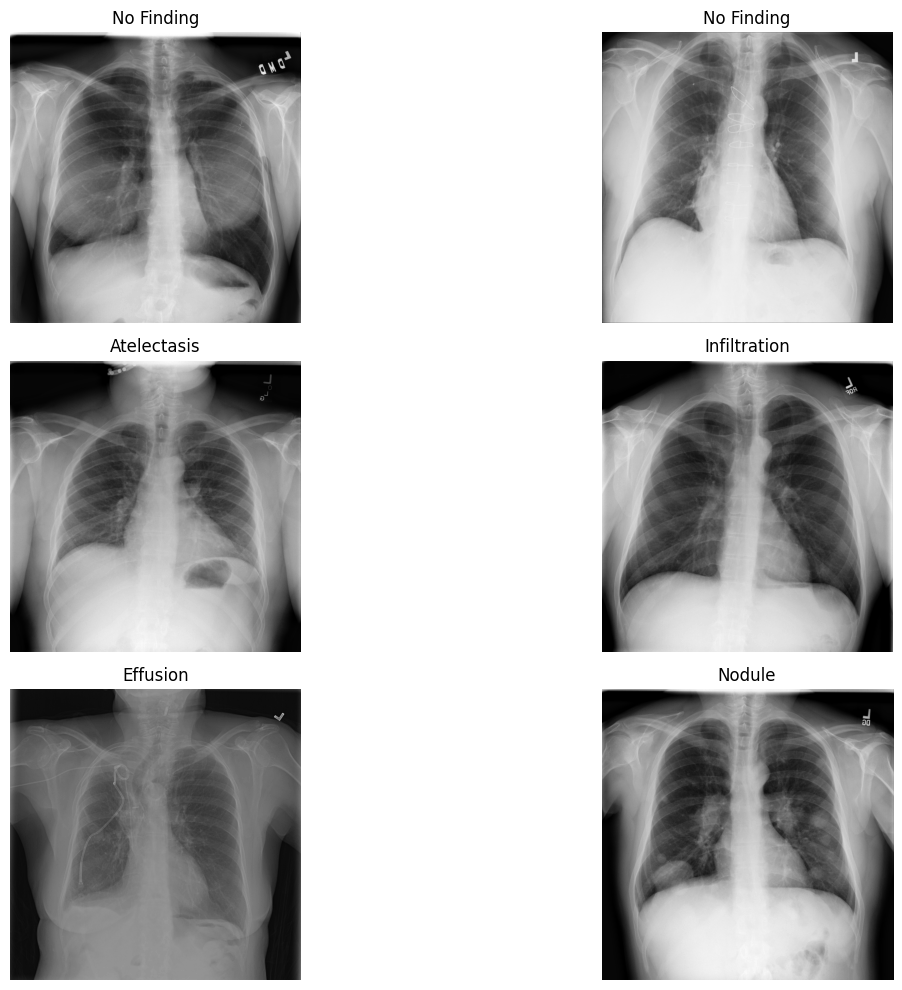

In [21]:
root_folder = "/kaggle/input/data/"

desired_counts = {'No Finding': 2, 'Atelectasis': 1, 'Infiltration': 1, 'Effusion': 1, 'Nodule': 1}

try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")

no_finding_images = df[df['Finding Labels'] == 'No Finding'].sample(2)['Image Index'].values

other_pathology_images = []
for label, count in desired_counts.items():
    if label != 'No Finding':
        other_pathology_images.extend(df[df['Finding Labels'] == label].sample(count)['Image Index'].values)

selected_images = list(no_finding_images) + other_pathology_images

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for i, img_name in enumerate(selected_images):
    img_path = [path for path in image_paths if img_name in path][0]  # Find the corresponding image path using img_name
    img = mpimg.imread(img_path)
    
    pathology = df[df['Image Index'] == os.path.basename(img_path)]['Finding Labels'].values[0]
    
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(pathology)

if len(selected_images) < 6:
    for i in range(len(selected_images), 6):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [22]:
df = sampled_df

In [23]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
79578,00019547_012.png,Atelectasis,12,19547,65,F
37561,00009892_024.png,Atelectasis,24,9892,62,F
30714,00008009_024.png,Atelectasis,24,8009,19,M
39397,00010319_004.png,Atelectasis,4,10319,59,M
39874,00010420_002.png,Atelectasis,2,10420,54,M


In [24]:
print(len(df))

14705


In [25]:
df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
111967,00030697_000.png,Nodule,0,30697,42,F
111975,00030703_000.png,Nodule,0,30703,58,F
111976,00030703_001.png,Nodule,1,30703,58,F
112001,00030722_000.png,Nodule,0,30722,45,F
112005,00030726_000.png,Nodule,0,30726,64,M


# Machine Learning Section

In [26]:
from tqdm.notebook import trange, tqdm

import torch as tc
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [27]:
%%capture

def create_image_path_series(directory):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory '{directory}' not found.")

    image_paths = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            try:
                filepath = os.path.join(dirname, filename)
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(filepath)
            except OSError as e:
                print(f"Error processing file '{filepath}': {e}")

    return pd.Series(image_paths, index=image_paths)

directory = "/kaggle/input"

try:
    image_path_series = create_image_path_series(directory)
    print(image_path_series)
except (FileNotFoundError, ValueError) as e:
    print(e)

In [28]:
df['Filepath'] = image_path_series[image_paths]

In [29]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['Image Index']
    for path_index, path in image_path_series.items():
        if filename in path:
            df.loc[index, 'Filepath'] = path
            break

  0%|          | 0/14705 [00:00<?, ?it/s]

In [30]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Filepath
79578,00019547_012.png,Atelectasis,12,19547,65,F,/kaggle/input/data/images_009/images/00019547_...
37561,00009892_024.png,Atelectasis,24,9892,62,F,/kaggle/input/data/images_005/images/00009892_...
30714,00008009_024.png,Atelectasis,24,8009,19,M,/kaggle/input/data/images_004/images/00008009_...
39397,00010319_004.png,Atelectasis,4,10319,59,M,/kaggle/input/data/images_005/images/00010319_...
39874,00010420_002.png,Atelectasis,2,10420,54,M,/kaggle/input/data/images_005/images/00010420_...


In [31]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [32]:
def one_epoch(net, loss, dl, opt=None, metric=None):

    if opt: net.train()  # only affects some layers
    else:   net.eval()

    L, M = [], []
    for xb, yb in tqdm(iter(dl), leave=False):
        if tc.cuda.is_available():
          xb, yb = xb.cuda(), yb.cuda()
        if opt:
            y_ = net(xb)
            l = loss(y_, yb)
            opt.zero_grad()
            l.backward()
            opt.step()
        else:
            with tc.no_grad():
                y_ = net(xb)
                l = loss(y_, yb)
        L.append(l.detach().cpu().numpy())
        if metric: M.append(metric(y_, yb).cpu().numpy())

    return L, M

In [33]:
accuracy = lambda y_,yb: (y_.max(dim=1)[1] == yb).float().mean()


# Modify the Hyper parameters to improve accuracy and reduce loss
def fit(net, tr_dl, val_dl, test_dl, loss=nn.CrossEntropyLoss(), epochs=10, lr=3e-3, wd=1e-3, plot=True):
    opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    scheduler = StepLR(opt, step_size=30, gamma=0.1)  # adjust the learning rate every 30 epochs

    best_val_loss = float('inf')
    best_model = None

    Ltr_hist, Lval_hist = [], []
    for epoch in trange(epochs):
        Ltr,  _    = one_epoch(net, loss, tr_dl,  opt)
        Lval, Aval = one_epoch(net, loss, val_dl, None, accuracy)

        # save the model with the lowest validation loss
        if np.mean(Lval) < best_val_loss:
            best_val_loss = np.mean(Lval)
            best_model = net.state_dict()
            torch.save(best_model, 'best_model_weights.pth')  # save the best model weights to a file

        scheduler.step() 

        Ltr_hist.append(np.mean(Ltr))
        Lval_hist.append(np.mean(Lval))
        print(f'epoch: {epoch}\ttraining loss: {np.mean(Ltr):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')

    net.load_state_dict(best_model)
    Ltest, Atest = one_epoch(net, loss, test_dl, None, accuracy)
    print(f'test loss: {np.mean(Ltest):0.4f}\ttest accuracy: {np.mean(Atest):0.2f}')

    if plot:
        _,ax = plt.subplots(1,1,figsize=(16,4))
        ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
        ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
        ax.grid('on')
        ax.set_xlim(left=1, right=len(Ltr_hist))
        ax.legend(['training loss', 'validation loss']);

    return Ltr_hist, Lval_hist

In [34]:
class ChestXRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.df['Encoded_Labels'] = self.label_encoder.fit_transform(self.df['Finding Labels'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Filepath']
        image = Image.open(img_path).convert('RGB')  # Load the image properly
        if self.transform:
            image = self.transform(image)
        target = tc.tensor(self.df.iloc[idx]['Encoded_Labels'], dtype=tc.long)
        return image, target


def collate_fn(batch):
    device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
    images, labels = zip(*batch)
    images = tc.stack([transforms.ToTensor()(img).to(device) for img in images]).to(device)
    labels = tc.tensor(labels).to(device)
    return images, labels

In [35]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

train_dataset = ChestXRayDataset(train_df)
val_dataset = ChestXRayDataset(val_df)
test_dataset = ChestXRayDataset(test_df)

batch_size = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle= False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [36]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Filepath,Encoded_Labels
108760,00029513_001.png,No Finding,1,29513,56,M,/kaggle/input/data/images_012/images/00029513_...,3
31635,00008270_017.png,No Finding,17,8270,58,M,/kaggle/input/data/images_004/images/00008270_...,3
75206,00018451_005.png,No Finding,5,18451,52,F,/kaggle/input/data/images_009/images/00018451_...,3
81967,00020166_002.png,Nodule,2,20166,56,M,/kaggle/input/data/images_009/images/00020166_...,4
80322,00019742_004.png,Atelectasis,4,19742,60,M,/kaggle/input/data/images_009/images/00019742_...,0


In [37]:
effnet = models.efficientnet_b1(pretrained=True)
effnet = effnet.to(device)

for param in effnet.parameters():
    param.requires_grad = False  

num_classes = len(train_df['Finding Labels'].unique())  # Assuming 'Finding Labels' has class labels
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)

for param in effnet.classifier.parameters():
    param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:03<00:00, 10.5MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 0	training loss: 1.6089	validation loss: 1.5603	validation accuracy: 0.31


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 1	training loss: 1.5883	validation loss: 1.4726	validation accuracy: 0.37


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 2	training loss: 1.5667	validation loss: 1.5153	validation accuracy: 0.34


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 3	training loss: 1.5668	validation loss: 1.5092	validation accuracy: 0.36


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 4	training loss: 1.5729	validation loss: 1.5419	validation accuracy: 0.36


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 5	training loss: 1.5549	validation loss: 1.4750	validation accuracy: 0.36


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 6	training loss: 1.5710	validation loss: 1.5205	validation accuracy: 0.33


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 7	training loss: 1.5662	validation loss: 1.4793	validation accuracy: 0.36


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 8	training loss: 1.5499	validation loss: 1.4715	validation accuracy: 0.37


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 9	training loss: 1.5566	validation loss: 1.4789	validation accuracy: 0.36


  0%|          | 0/184 [00:00<?, ?it/s]

test loss: 1.4762	test accuracy: 0.36
CPU times: user 1h 38min 27s, sys: 38.5 s, total: 1h 39min 6s
Wall time: 1h 28min 16s


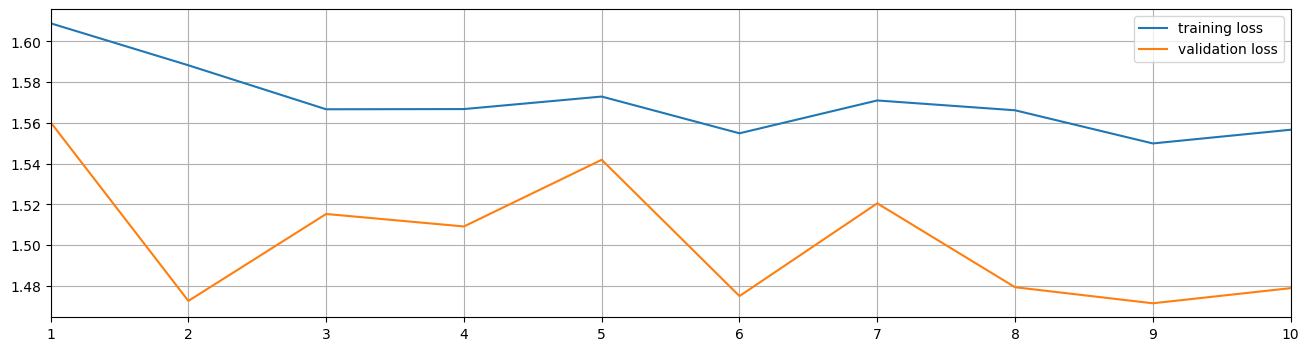

In [38]:
%%time
fit(effnet.cuda(), train_loader, val_loader, test_loader);

In [39]:
effnet = models.efficientnet_b0(pretrained=True)
effnet = effnet.to(device)

for param in effnet.parameters():
    param.requires_grad = False  

num_classes = len(train_df['Finding Labels'].unique())  # Assuming 'Finding Labels' has class labels
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)

for param in effnet.classifier.parameters():
    param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 49.2MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 0	training loss: 1.5846	validation loss: 1.4930	validation accuracy: 0.34


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 1	training loss: 1.5551	validation loss: 1.5382	validation accuracy: 0.35


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 2	training loss: 1.5463	validation loss: 1.5092	validation accuracy: 0.33


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 3	training loss: 1.5340	validation loss: 1.4557	validation accuracy: 0.36


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 4	training loss: 1.5301	validation loss: 1.4782	validation accuracy: 0.35


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 5	training loss: 1.5089	validation loss: 1.5034	validation accuracy: 0.37


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 6	training loss: 1.5233	validation loss: 1.4892	validation accuracy: 0.36


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 7	training loss: 1.5329	validation loss: 1.4981	validation accuracy: 0.34


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 8	training loss: 1.5237	validation loss: 1.4631	validation accuracy: 0.37


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 9	training loss: 1.5215	validation loss: 1.4801	validation accuracy: 0.36


  0%|          | 0/184 [00:00<?, ?it/s]

test loss: 1.4797	test accuracy: 0.35
CPU times: user 1h 25min 22s, sys: 30.6 s, total: 1h 25min 53s
Wall time: 1h 12min 24s


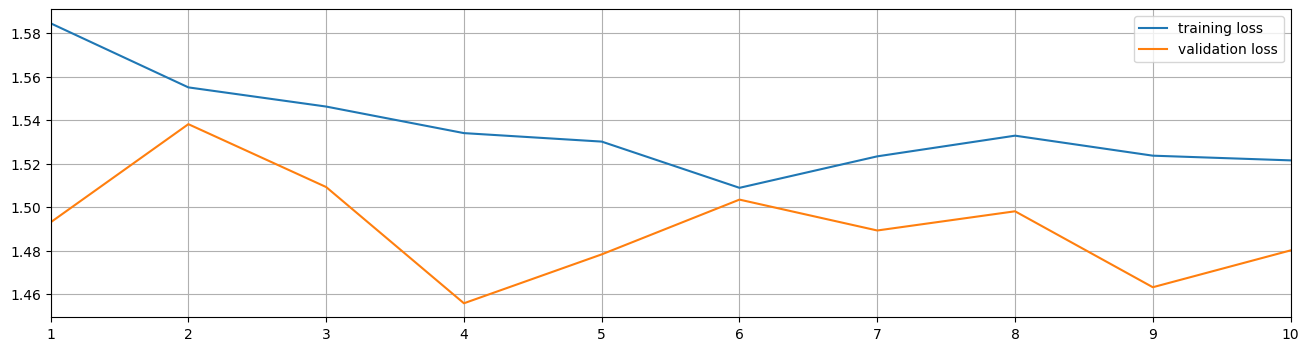

In [40]:
# %%time
# fit(effnet.cuda(), train_loader, val_loader, test_loader);

In [41]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

for param in effnet.parameters():
    param.requires_grad = False  

num_classes = len(train_df['Finding Labels'].unique())  # Assuming 'Finding Labels' has class labels
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)

for param in effnet.classifier.parameters():
    param.requires_grad = True


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.9MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 0	training loss: 1.7225	validation loss: 2.9687	validation accuracy: 0.18


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 1	training loss: 1.6489	validation loss: 1.6494	validation accuracy: 0.23


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 2	training loss: 1.6343	validation loss: 1.6412	validation accuracy: 0.24


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 3	training loss: 1.5992	validation loss: 1.5946	validation accuracy: 0.29


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 4	training loss: 1.5958	validation loss: 1.6925	validation accuracy: 0.23


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 5	training loss: 1.5989	validation loss: 1.7433	validation accuracy: 0.24


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 6	training loss: 1.5886	validation loss: 2.5783	validation accuracy: 0.22


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 7	training loss: 1.5866	validation loss: 1.8670	validation accuracy: 0.24


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 8	training loss: 1.5752	validation loss: 1.5784	validation accuracy: 0.25


  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

epoch: 9	training loss: 1.5753	validation loss: 1.8053	validation accuracy: 0.23


  0%|          | 0/184 [00:00<?, ?it/s]

test loss: 1.7925	test accuracy: 0.22
CPU times: user 1h 43min 5s, sys: 37.3 s, total: 1h 43min 42s
Wall time: 1h 29min 30s


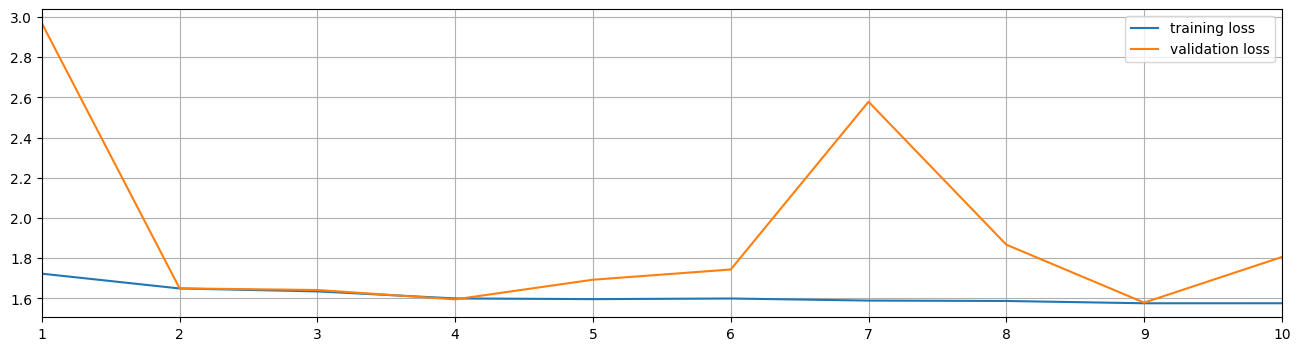

In [42]:
# %%time
# fit(resnet18.cuda(), train_loader, val_loader, test_loader);

In [ ]:
from torchvision.models import inception_v3

inception = inception_v3(pretrained=True)
inception = inception.to(device)

for param in inception.parameters():
    param.requires_grad = False  

num_ftrs = inception.fc.in_features
num_classes = len(train_df['Finding Labels'].unique())
inception.fc = nn.Linear(num_ftrs, num_classes)

for param in inception.fc.parameters():
    param.requires_grad = True

In [ ]:
%%time
fit(inception.cuda(), train_loader, val_loader, test_loader);

In [43]:
# mbnet = models.mobilenet_v2(pretrained=True)
# mbnet = mbnet.to(device)

# for param in effnet.parameters():
#     param.requires_grad = False  

# num_classes = len(train_df['Finding Labels'].unique())  # Assuming 'Finding Labels' has class labels
# effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)

# for param in effnet.classifier.parameters():
#     param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 73.6MB/s]


In [44]:
# %%time
# fit(mbnet.cuda(), train_loader, val_loader, test_loader);

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 144.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 162.12 MiB is free. Process 2534 has 15.73 GiB memory in use. Of the allocated memory 15.03 GiB is allocated by PyTorch, and 399.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# STOP........STOP..........STOP........STOP

In [ ]:
# Get the file paths of the first 8 images in the DataFrame
img_paths = df['Filepath'].iloc[:8]

# Initialize a list to store the image tensors
images = []

# Open each image, preprocess it, and add it to the list
for img_path in img_paths:
    image = Image.open(img_path)
    image = transform(image)
    images.append(image)

# Stack the image tensors together to form a batch
images = torch.stack(images)

# Move the batch tensor to the device
images = images.to(device)

# Pass the batch through the model
output = inception(images)

# Get the predicted classes
_, predicted_classes = torch.max(output, 1)

# Convert tensor of predicted classes to list
predicted_classes = predicted_classes.tolist()

# Plot the images with their predicted and actual classes
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, img_path in enumerate(img_paths):
    # Open and display the image
    img = Image.open(img_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    # Get the actual class from the DataFrame
    actual_class = df[df['Filepath'] == img_path]['Finding Labels'].values[0]

    # Get the predicted class
    predicted_class = predicted_classes[i]

    # Set the title to the actual and predicted classes
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

In [ ]:
# %%capture
# !tar -czvf new_cv_data.tar.gz NEW_CV_DATA/

In [ ]:
# FileLink(r'new_cv_data.tar.gz')

## Training Function Definitions

In [ ]:
# def save_best_model(model, val_loss, best_val_loss, best_model_wts):
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model_wts = copy.deepcopy(model.state_dict())
#         # Save the model weights to a file
#         torch.save(best_model_wts, '/kaggle/working/best_model_weights.pth')
#     return best_val_loss, best_model_wts

In [ ]:
# def calculate_metrics(y_true, y_pred):
#     precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
#     recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
#     f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    
#     report = classification_report(y_true, y_pred)
    
#     metrics = {
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Classification Report': report
#     }
    
#     return metrics

In [ ]:
# def plot_metrics(metrics_list, test_loss_list, test_acc_list):
#     num_epochs = len(metrics_list)
#     metrics_names = ['Precision', 'Recall', 'F1 Score'] 
    
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#     for i, metric_name in enumerate(metrics_names):
#         row = i // 2
#         col = i % 2
#         train_values = [metric['Train'][metric_name] for metric in metrics_list]  
#         val_values = [metric['Validation'][metric_name] for metric in metrics_list]  
#         epoch_range = range(1, num_epochs + 1)

#         axes[row, col].plot(epoch_range, train_values, label='Train', marker='o', linestyle='-')
#         axes[row, col].plot(epoch_range, val_values, label='Validation', marker='o', linestyle='-')
#         axes[row, col].set_title(metric_name)
#         axes[row, col].set_xlabel('Epoch')
#         axes[row, col].set_ylabel(metric_name)
#         axes[row, col].legend()

#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(test_loss_list, label='Test Loss', color='red')
#     plt.title('Test Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(test_acc_list, label='Test Accuracy', color='blue')
#     plt.title('Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

In [ ]:
# def test_model(model, test_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct_predictions = 0
#     total_predictions = 0
    
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs, 1)
#             correct_predictions += (predicted == labels).sum().item()
#             total_predictions += labels.size(0)
    
#     test_loss = running_loss / len(test_loader.dataset)
#     test_acc = correct_predictions / total_predictions
    
#     return test_loss, test_acc


In [ ]:
# def plot_test(test_loss, test_acc):
#     # Plot test loss
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(test_loss, label='Test Loss', color='red')
#     plt.title('Test Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot test accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(test_acc, label='Test Accuracy', color='blue')
#     plt.title('Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

## Model training and evaluation

In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
# criterion = nn.CrossEntropyLoss()
# best_val_loss = float('inf')
# best_model_wts = None
# num_epochs = 5

# metrics_list = []
# test_loss_list = []
# test_acc_list = []

# for epoch in range(num_epochs): 
#     true_labels_train = []  
#     predicted_labels_train = []
#     true_labels_val = []
#     predicted_labels_val = []

#     train_loader_tqdm = tqdm(train_loader, desc='Training', total=len(train_loader))
#     val_loader_tqdm = tqdm(val_loader, desc='Validation', total=len(val_loader))

#     model.train()
#     running_train_loss = 0.0
#     correct_train_predictions = 0
#     total_train_predictions = 0

#     for inputs, labels in train_loader_tqdm:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_train_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct_train_predictions += (predicted == labels).sum().item()
#         total_train_predictions += labels.size(0)

#         true_labels_train.extend(labels.cpu().numpy())
#         predicted_labels_train.extend(predicted.cpu().numpy())

#     train_loss = running_train_loss / len(train_loader.dataset)
#     train_acc = correct_train_predictions / total_train_predictions

#     # Validation phase
#     model.eval()
#     running_val_loss = 0.0
#     correct_val_predictions = 0
#     total_val_predictions = 0

#     for inputs, labels in val_loader_tqdm:
#         inputs, labels = inputs.to(device), labels.to(device)

#         outputs = model(inputs)
        
#         loss = criterion(outputs, labels)

#         running_val_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct_val_predictions += (predicted == labels).sum().item()
#         total_val_predictions += labels.size(0)
        
#         true_labels_val.extend(labels.cpu().numpy())
#         predicted_labels_val.extend(predicted.cpu().numpy())

#     val_loss = running_val_loss / len(val_loader.dataset)
#     val_acc = correct_val_predictions / total_val_predictions

#     # Calculate metrics for this epoch for both training and validation
#     epoch_metrics_train = calculate_metrics(true_labels_train, predicted_labels_train)
#     epoch_metrics_val = calculate_metrics(true_labels_val, predicted_labels_val)
    
#     # Append both sets of metrics to the metrics_list
#     metrics_list.append({'Train': epoch_metrics_train, 'Validation': epoch_metrics_val})
#     test_loss, test_acc = test_model(model, test_loader, criterion, device)    
#     test_loss_list.append(test_loss)
#     test_acc_list.append(test_acc)
    
#     scheduler.step(val_acc)

#     print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

#     best_val_loss, best_model_wts = save_best_model(model, val_loss, best_val_loss, best_model_wts)

#     model.load_state_dict(best_model_wts)

#     train_loader_tqdm.close()
#     val_loader_tqdm.close()

# Performance Visualisation

In [ ]:
# plot_metrics(metrics_list, test_loss_list, test_acc_list)

In [ ]:
# test_loss, test_acc = test_model(model, test_loader, criterion, device)
# print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# TensorRT

In [ ]:
!apt-get install -y libnvinfer-dev libnvinfer-dispatch-dev libnvinfer-dispatch8 \
                    libnvinfer-headers-dev libnvinfer-headers-plugin-dev \
                    libnvinfer-lean-dev libnvinfer-lean8 libnvinfer-plugin-dev \
                    libnvinfer-vc-plugin-dev libnvonnxparsers-dev libnvparsers-dev \
                    python3-libnvinfer-dev python3-libnvinfer-dispatch \
                    python3-libnvinfer-lean

In [ ]:
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt
%cd torch2trt
!python setup.py install --plugins

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the 6-class model
model = EfficientNet.from_pretrained('efficientnet-b1')
for param in model.parameters():
    param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True
num_classes = 5
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, num_classes)
model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('/kaggle/working/best_model_weights.pth'))
# After training, convert the trained model to TensorRT
model_trt = torch2trt.torch2trt(model, [torch.randn(1, 3, 224, 224).to(device)])

model.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ChestXRayDataset(train_df, transform=transform)
val_dataset = ChestXRayDataset(val_df, transform=transform)
test_dataset = ChestXRayDataset(test_df, transform=transform)

batch_size = 16

def collate_fn(batch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images, labels = zip(*batch)
    images = torch.stack([img.to(device) for img in images])
    labels = torch.tensor(labels).to(device)
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
# criterion = nn.CrossEntropyLoss()
# best_val_loss = float('inf')
# best_model_wts = None
# num_epochs = 5

# metrics_list = []
# test_loss_list = []
# test_acc_list = []

# for epoch in range(num_epochs): 
#     true_labels_train = []  
#     predicted_labels_train = []
#     true_labels_val = []
#     predicted_labels_val = []

#     train_loader_tqdm = tqdm(train_loader, desc='Training', total=len(train_loader))
#     val_loader_tqdm = tqdm(val_loader, desc='Validation', total=len(val_loader))

#     model.train()
#     running_train_loss = 0.0
#     correct_train_predictions = 0
#     total_train_predictions = 0

#     for inputs, labels in train_loader_tqdm:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_train_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct_train_predictions += (predicted == labels).sum().item()
#         total_train_predictions += labels.size(0)

#         true_labels_train.extend(labels.cpu().numpy())
#         predicted_labels_train.extend(predicted.cpu().numpy())

#     train_loss = running_train_loss / len(train_loader.dataset)
#     train_acc = correct_train_predictions / total_train_predictions

#     # Validation phase
#     model.eval()
#     running_val_loss = 0.0
#     correct_val_predictions = 0
#     total_val_predictions = 0

#     for inputs, labels in val_loader_tqdm:
#         inputs, labels = inputs.to(device), labels.to(device)

#         outputs = model(inputs)
        
#         loss = criterion(outputs, labels)

#         running_val_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct_val_predictions += (predicted == labels).sum().item()
#         total_val_predictions += labels.size(0)
        
#         true_labels_val.extend(labels.cpu().numpy())
#         predicted_labels_val.extend(predicted.cpu().numpy())

#     val_loss = running_val_loss / len(val_loader.dataset)
#     val_acc = correct_val_predictions / total_val_predictions

#     # Calculate metrics for this epoch for both training and validation
#     epoch_metrics_train = calculate_metrics(true_labels_train, predicted_labels_train)
#     epoch_metrics_val = calculate_metrics(true_labels_val, predicted_labels_val)
    
#     # Append both sets of metrics to the metrics_list
#     metrics_list.append({'Train': epoch_metrics_train, 'Validation': epoch_metrics_val})
#     test_loss, test_acc = test_model(model, test_loader, criterion, device)    
#     test_loss_list.append(test_loss)
#     test_acc_list.append(test_acc)
    
#     scheduler.step(val_acc)

#     print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

#     best_val_loss, best_model_wts = save_best_model(model, val_loss, best_val_loss, best_model_wts)

#     model.load_state_dict(best_model_wts)

#     train_loader_tqdm.close()
#     val_loader_tqdm.close()

# Visualise Performance

In [ ]:
plot_metrics(metrics_list, test_loss_list, test_acc_list)

In [ ]:
test_loss, test_acc = test_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')